In [1]:
#instruction to be able to zoom on matplotlib figure
%matplotlib widget 


import sys
sys.path.insert(0,'../source')
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
from datetime import date

#from datetime import datetime

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# Import module for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, corr_data, copy_attr
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_corr_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa
from m_users_plot import plot_cmp_corr_NCEP_old, plot_cmp_corr_WOA_old
from m_read_write_netcdf import corr_file

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_16103/3403662524.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
#
# Init.
#

# plot or no ?
info_plot = 1 # 0 : some plots are not created, 1 : all plots

# WMO Float (string format)
num_float = '6903080'
first_cycle_to_use = 1
last_cycle_to_use = 73 #231 #71 # Cycle to use to estimate a correction

# Ctd comparison to estimate a supplement gain.
cmp_ctd = 1 # 1 if we used CTD for comparison, 0 otherwise
num_cycle = np.array([6]) # Cycle to compare to CTD
rep_ctd = ['//Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/']
fic_ctd = ['bo21_PRES.nc'] # Netcdf File with CTD
#rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/RREX/RREX17/']
#fic_ctd = ['rr17_PRES.nc']
num_ctd = np.array([22]) # Rapport TR : CTD 82 indiqué mais selon tracé dans rapport, c'est station 26 ....Station Number to compare

# Do we correct data from a pressure effect ?
#corr_pres_effect = 1 # 1 if we estimate a correction effect pressure, 0 otherwise
pressure_threshold = 1500  # Pressure for pressure effect estimation. We use pressure > pressure_threshold

# ARGO directory : Directory where you can find 1 directory per WMO ARGO float.
# In the WMO float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
#rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
rep_data_argo = '/Volumes/ref-argo/gdac/dac/coriolis/'

# The WOA file containing the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# this file is created by an internal LOPS routine.
#
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'

# which variable to used :
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2

#
# Which PSAT to used :
# which_psat = 1 : We use PSAT from WOA file
# which_psat = 2 We use PSAT calculated as Locodox
which_psat = 2
# Min and Max pressure to average WOA and ARGO PPOX
min_pres_interp = 0
max_pres_interp = 25

# Which QC used for pressure, temperature, salinity and oxygen.
# In Sprof, we got interpolated data (flag=8)
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

percent_relative_error = 2.0

In [3]:
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/ref-argo/gdac/dac/coriolis/6903080/6903080_meta.nc
/Volumes/ref-argo/gdac/dac/coriolis/6903080/6903080_Sprof.nc
/Volumes/ref-argo/gdac/dac/coriolis/6903080/6903080_Rtraj.nc


In [4]:
ds_argo_Sprof = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Sprof['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Rtraj = ds_argo_Rtraj.where( (ds_argo_Rtraj['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Rtraj['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Sprof['PLATFORM_NUMBER'] = ds_argo_Sprof['PLATFORM_NUMBER'].astype(int) # The where transform the nan from int to float ...

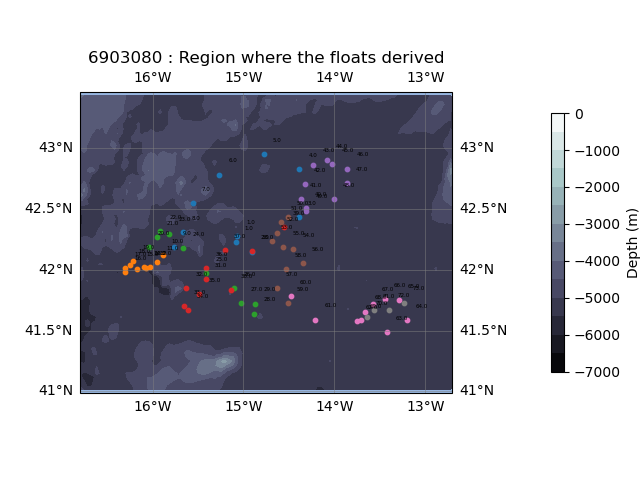

In [5]:
if info_plot==1:
    fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
    ds_bathy = xr.open_dataset(fic_bathy)

    extend_lon_lat = 0.5
    depths = np.arange(-7000,500,500)
    plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)

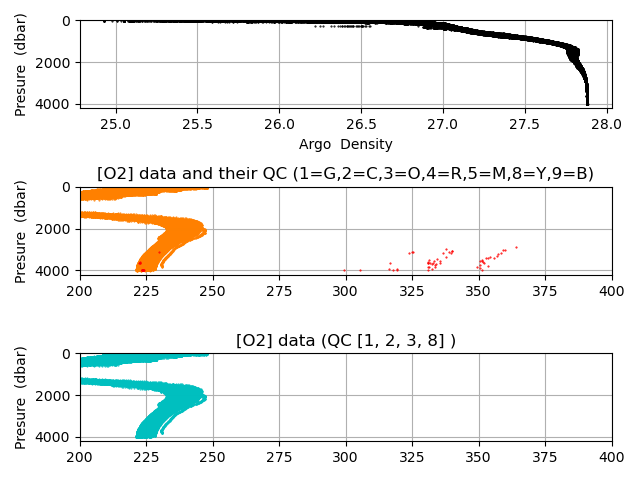

In [6]:
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc)

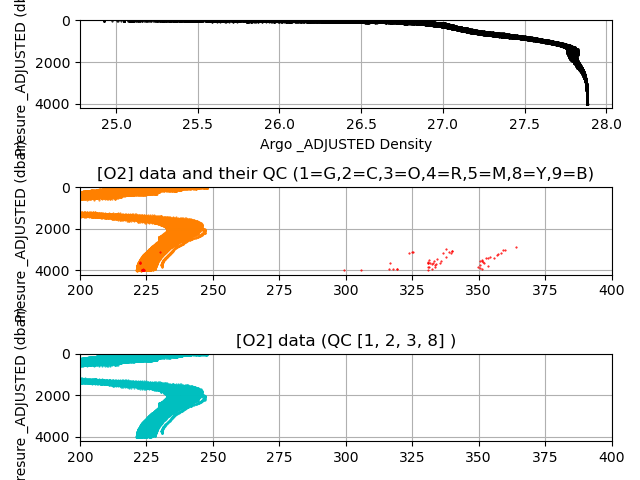

In [7]:
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')

PRES
TEMP
PSAL


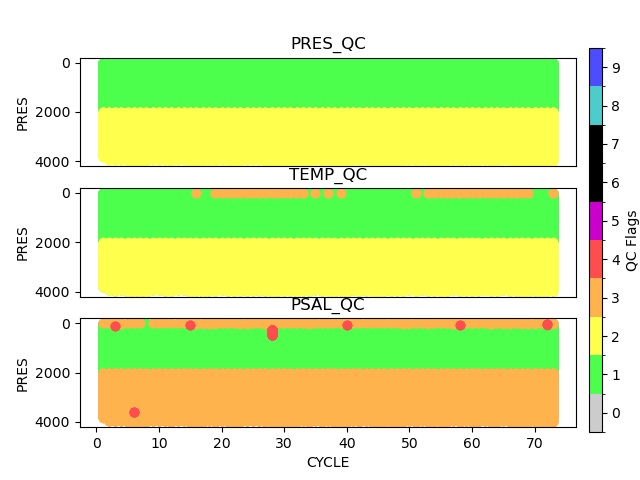

In [8]:
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof)

PRES_ADJUSTED
TEMP_ADJUSTED
PSAL_ADJUSTED


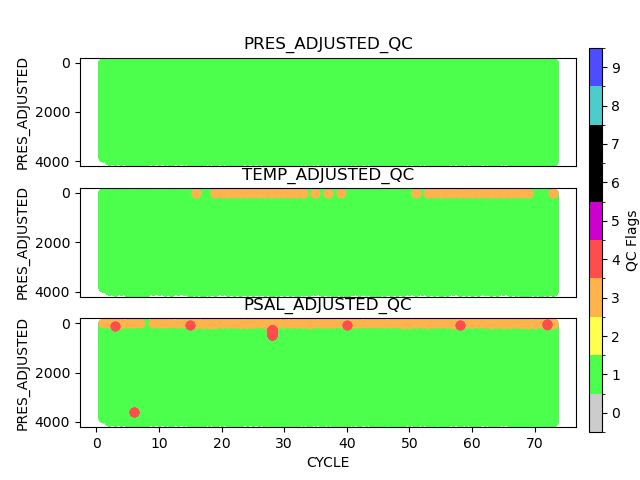

In [9]:
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')

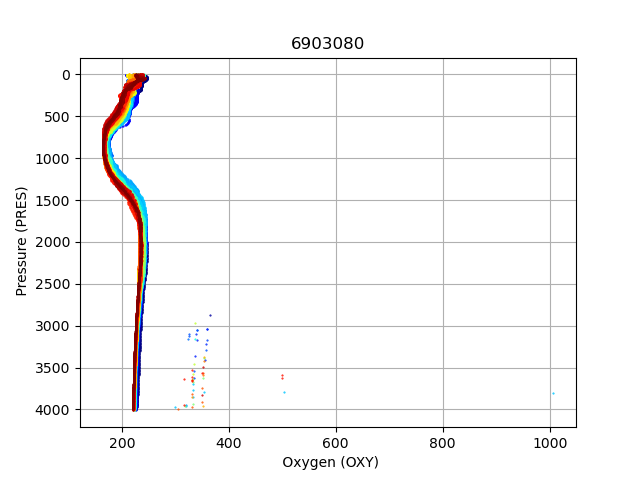

In [10]:
_=plot_DOXY_cycle(ds_argo_Sprof)

In [11]:
#plt.figure()
#_=plt.plot(ds_argo_Sprof['DOXY'][0:15],ds_argo_Sprof['PRES'][0:15],'.b')
#_=plt.plot(ds_argo_Sprof['DOXY'][16:20],ds_argo_Sprof['PRES'][16:20],'.r')
#plt.gca().invert_yaxis()
#plt.grid()
#plt.figure()
#_=plt.plot(ds_argo_Sprof['LONGITUDE'][0:15],ds_argo_Sprof['LATITUDE'][0:15],'.-b')
#_=plt.plot(ds_argo_Sprof['LONGITUDE'][16:20],ds_argo_Sprof['LATITUDE'][16:20],'.-r')


In [12]:
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2021-06-05T18:12:00.000000000
-0.3


In [13]:
delta_T_sprof = diff_time_in_days(ds_argo_Sprof['JULD'],launch_date)


In [14]:
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


In [15]:
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [16]:
ds_woa = open_WOA_file(fic_WOA)
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset> Size: 4GB
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 96B 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 1kB ...
    longitude  (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    density    (time, N_LEVELS, lat, lon) float64 635MB ...
    preswoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...

In [17]:
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset> Size: 4GB
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 112B -15.25 15.0 46.0 75.0 ... 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    density   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
101.86589

In [18]:
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]

# Interpolation WOA et ARGO sur une grille reguliere en pression.
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [19]:
#for var in ds_argo_interp.data_vars :
#    ds_argo_interp[var].attrs = ds_argo[var].attrs    
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [20]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

We calculate PSAT as Locodox Matlab does


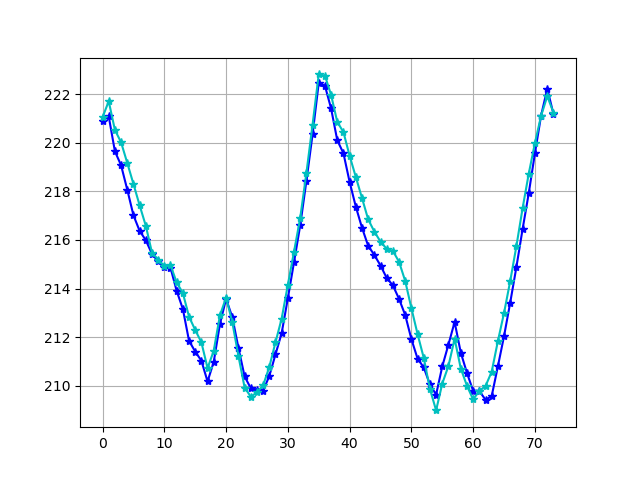

In [21]:
if which_psat == 2:
    print('We calculate PSAT as Locodox Matlab does')
    ana_dens_woa = sw.pden(ds_woa_interp['PSAL_WOA'],ds_woa_interp['TEMP_WOA'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
    O2_ARGO_umolL = umolkg_to_umolL(ds_woa_interp['doxywoa'],ds_argo['DOXY_ARGO'].units,ana_dens_woa)
    psatwoaV2 = O2ctoO2s(O2_ARGO_umolL,ds_woa_interp['TEMP_WOA'],ds_woa_interp['PSAL_WOA'])
    ppox_WOA2 = O2stoO2p(psatwoaV2,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
    ppox_WOA_mean2 = np.nanmean(ppox_WOA2,axis=1)

    plt.figure()
    plt.plot(ppox_WOA_mean,'*-b')
    plt.plot(ppox_WOA_mean2,'*-c')
    plt.grid()

    ppox_WOA_mean = ppox_WOA_mean2

In [22]:
#plt.figure()
#_=plt.plot(delta_T_WOA,np.nanmean(psatwoaV2,axis=1),'*-b')
#_=plt.plot(np.nanmean(ds_woa_interp['Psatwoa'],axis=1),'o-r')
#plt.grid()

In [23]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [24]:
# Correction : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
#params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean, ppox_WOA_mean, p0=initial_guess,nan_policy='omit')
#print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')


In [25]:
# Correction : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
#params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean, p0=initial_guess,nan_policy='omit',full_output=True)
#print(params_Gain_Derive_WOA)

initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)

In [26]:
# NCEP Correction
# Download NCEP Data
download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)
#annee_to_download = [min(ds_argo['JULD'].dt.year).values,max(ds_argo['JULD'].dt.year).values]
#download_NCEP_force(annee_to_download,ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

File slp.2021.nc already exists with the same size. No Download
File air.sig995.2021.nc already exists with the same size. No Download
File rhum.sig995.2021.nc already exists with the same size. No Download
File slp.2022.nc already exists with the same size. No Download
File air.sig995.2022.nc already exists with the same size. No Download
File rhum.sig995.2022.nc already exists with the same size. No Download
File slp.2023.nc already exists with the same size. No Download
File air.sig995.2023.nc already exists with the same size. No Download
File rhum.sig995.2023.nc already exists with the same size. No Download


We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


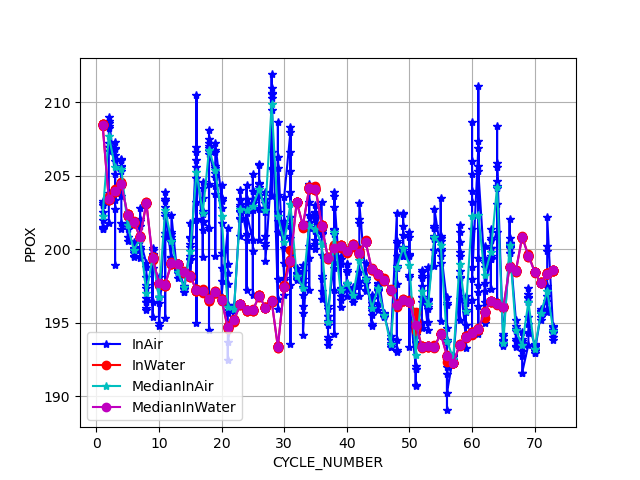

PSAL_ADJUSTED Data is used


In [27]:
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)

In [28]:
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])

z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [29]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)

In [30]:
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
params_Gain_NCEP, covariance = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit')

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [31]:
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

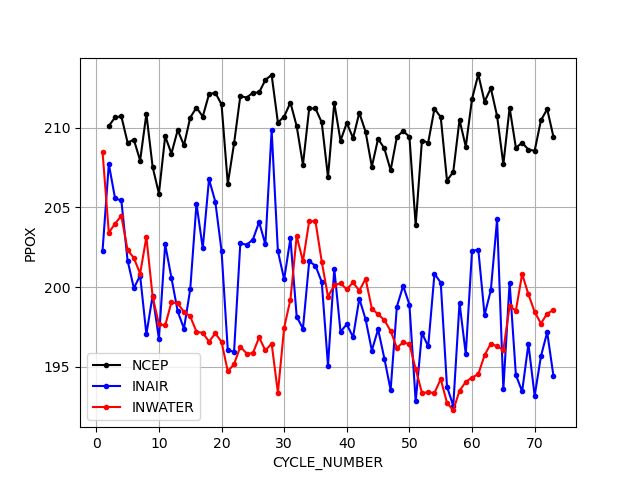

In [32]:
_ = plot_ppox_Inair_Inwater_Ncep(dsair,dsinwater,NCEP_PPOX)

In [33]:
print(params_Gain_NCEP_CarryOver)
print(params_Gain_Derive_NCEP_CarryOver)
print(params_Gain_NCEP_CarryOver)
print(params_Gain_Derive_NCEP_CarryOver)
params_Gain_NCEP_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
params_Gain_Derive_NCEP_CarryOver = np.array(params_Gain_Derive_NCEP_CarryOver[[0,2]])
print(params_Gain_NCEP_CarryOver)
print(params_Gain_Derive_NCEP_CarryOver)

[ 1.05556815 -0.68622397]
[ 1.03977712 -0.51489365  1.4770446 ]
[ 1.05556815 -0.68622397]
[ 1.03977712 -0.51489365  1.4770446 ]
[1.05556815]
[1.03977712 1.4770446 ]


In [34]:
#
# Correction par morceaux.
#
# Si correction par morceaux, on suppose une derive.
# Si jamais l'utilisateur constate un saut, alors il doit traiter les données en plusieurs fois (par exemple : traitement du cycle 1 à N, ouis du cycle N+1 a M, etc
#
breakpoints_cycle = [1,15,ds_argo_Sprof['CYCLE_NUMBER'].values[-1]] 

params_morceaux_Gain_Derive_NCEP = []
params_morceaux_Gain_Derive_CarryOver = []
params_morceaux_Gain_Derive_WOA = []


for i in range(len(breakpoints_cycle) - 1):
    #
    # Correction NCEP.
    #
    mask = (dsair['CYCLE_NUMBER']>=breakpoints_cycle[i]) & (dsair['CYCLE_NUMBER']<=breakpoints_cycle[i+1])
    var1_seg = PPOX1[mask]
    var2_seg = PPOX2[mask]
    delta_T_seg = delta_T_NCEP[mask]

    initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
    val_bid,_ = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], NCEP_PPOX[mask]/var1_seg, p0=initial_guess,nan_policy='omit')
    
    params_morceaux_Gain_Derive_NCEP.append(val_bid)

    initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
    val_bid, _ = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],NCEP_PPOX[mask],p0=initial_guess,nan_policy='omit')
    params_morceaux_Gain_Derive_CarryOver.append(val_bid)

    #
    # Correction pour WOA.
    #
    initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
    mask = (ds_argo['CYCLE_NUMBER']>=breakpoints_cycle[i]) & (ds_argo['CYCLE_NUMBER']<=breakpoints_cycle[i+1])
    var1_seg = ppox_ARGO_mean[mask]
    delta_T_seg = delta_T_WOA[mask]
    val_bid,_ = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ppox_WOA_mean[mask]/var1_seg, p0=initial_guess,nan_policy='omit')
    params_morceaux_Gain_Derive_WOA.append(val_bid)


print(params_morceaux_Gain_Derive_NCEP)
print(params_morceaux_Gain_Derive_CarryOver)
print(params_morceaux_Gain_Derive_WOA)

[array([1.02197312, 9.06857456]), array([1.03329312, 1.82532007])]
[array([ 1.02424159, -3.24190522,  8.46759195]), array([ 1.04387341, -0.49771971,  1.17514929])]
[array([1.06800355, 1.61704548]), array([1.07558829, 0.91836414])]


In [35]:
#
# Correction par morceaux.
#
# Si correction par morceaux, on suppose une derive.
# Si jamais l'utilisateur constate un saut, alors il doit traiter les données en plusieurs fois (par exemple : traitement du cycle 1 à N, ouis du cycle N+1 a M, etc
#

params_morceaux_Gain_Derive_NCEP = []
params_morceaux_Gain_Derive_CarryOver = []
params_morceaux_Gain_Derive_WOA = []

residu1 = 999
residu2 = 999
residu3 = 999
cycle_a_garder1 = 0
cycle_a_garder2 = 0
cycle_a_garder3 = 0

for i_cycle in range(15,16):
    val_bid_res1 = 0
    val_bid_res2 = 0
    val_bid_res3 = 0
    params_a_garder1 = []
    params_a_garder2 = []
    params_a_garder3 = []
    test_ok = 1

    #print(i_cycle,val_bid_res1,val_bid_res2, val_bid_res3,test_ok )

    
    breakpoints_cycle = [0,i_cycle,ds_argo_Sprof['CYCLE_NUMBER'].values[-1]] 
    
    for i in range(len(breakpoints_cycle) - 1):
        #
        # Correction NCEP.
        #
        mask = (dsair['CYCLE_NUMBER']>=breakpoints_cycle[i]) & (dsair['CYCLE_NUMBER']<=breakpoints_cycle[i+1])
        
        if len(PPOX1[mask])<3: # Il faut au moins 3 valeurs pour utiliser model_Gain_Derive_CarryOver
            print(f'Decoupage au cycle {i_cycle} ne permet pas d\'avoir assez de donnees pour estimer le calcul')
            test_ok = 0
            break
            
        var1_seg = PPOX1[mask]
        var2_seg = PPOX2[mask]
        delta_T_seg = delta_T_NCEP[mask]

        initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
        val_bid,covariance,info,mesg,ier= curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], NCEP_PPOX[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
        val_bid_res1 = val_bid_res1 + np.nansum((info['fvec']**2)/len(info['fvec']))
        params_a_garder1.append(val_bid)
        
                             
        initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
        val_bid, covariance,info,mesg,ier = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],NCEP_PPOX[mask],p0=initial_guess,nan_policy='omit',full_output=True)
        val_bid_res2  = val_bid_res2 + np.nansum((info['fvec']**2)/len(info['fvec']))
        params_a_garder2.append(val_bid)

        #
        # Correction pour WOA.
        #
        initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
        mask = (ds_argo['CYCLE_NUMBER']>=breakpoints_cycle[i]) & (ds_argo['CYCLE_NUMBER']<=breakpoints_cycle[i+1])
        var1_seg = ppox_ARGO_mean[mask]
        delta_T_seg = delta_T_WOA[mask]
        val_bid,covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ppox_WOA_mean[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
        val_bid_res3 = val_bid_res3 + np.nansum((info['fvec']**2)/len(info['fvec']))
        params_a_garder3.append(val_bid)

    print(i_cycle,val_bid_res1,val_bid_res2, val_bid_res3,test_ok )
    
    if (val_bid_res1 < residu1) & (test_ok==1) :
        cycle_a_garder1 = i_cycle
        residu1 = val_bid_res1
        params_morceaux_Gain_Derive_NCEP = params_a_garder1
                
    if (val_bid_res2 < residu2) & (test_ok==1) :
        cycle_a_garder2 = i_cycle
        residu2 = val_bid_res2
        params_morceaux_Gain_Derive_CarryOver = params_a_garder2

    if (val_bid_res3 < residu3) & (test_ok==1) :
        cycle_a_garder3 = i_cycle
        residu3 = val_bid_res3
        params_morceaux_Gain_Derive_WOA = params_a_garder3

#params_morceaux_Gain_Derive_NCEP.append(params_a_garder1)
#params_morceaux_Gain_Derive_CarryOver.append(params_a_garder2)
#params_morceaux_Gain_Derive_WOA.append(params_a_garder3)



15 0.0002194958820012981 2.2167008613177757 0.00017996683070059424 1


In [36]:
print(params_morceaux_Gain_Derive_NCEP,cycle_a_garder1)
print(params_morceaux_Gain_Derive_CarryOver,cycle_a_garder2,residu2)
print(params_morceaux_Gain_Derive_WOA,cycle_a_garder3,residu3)

[array([1.02197312, 9.06857456]), array([1.03329312, 1.82532007])] 15
[array([ 1.02424159, -3.24190522,  8.46759195]), array([ 1.04387341, -0.49771971,  1.17514929])] 15 2.2167008613177757
[array([1.06800355, 1.61704548]), array([1.07558829, 0.91836414])] 15 0.00017996683070059424


In [37]:
params_morceaux_Gain_Derive_NCEP = np.array(params_morceaux_Gain_Derive_NCEP)
params_morceaux_Gain_Derive_CarryOver = np.array(params_morceaux_Gain_Derive_CarryOver)
params_morceaux_Gain_Derive_CarryOver = params_morceaux_Gain_Derive_CarryOver[:, [0, 2]]
params_morceaux_Gain_Derive_WOA = np.array(params_morceaux_Gain_Derive_WOA)

In [38]:
#print(params_morceaux_Gain_Derive_NCEP)
#print(type(params_morceaux_Gain_Derive_NCEP))

#print(params_morceaux_Gain_Derive_NCEP[0,0])
#print(params_morceaux_Gain_Derive_NCEP[0,1])
#print(params_morceaux_Gain_Derive_NCEP[1,0])
#print(params_morceaux_Gain_Derive_NCEP[1,1])

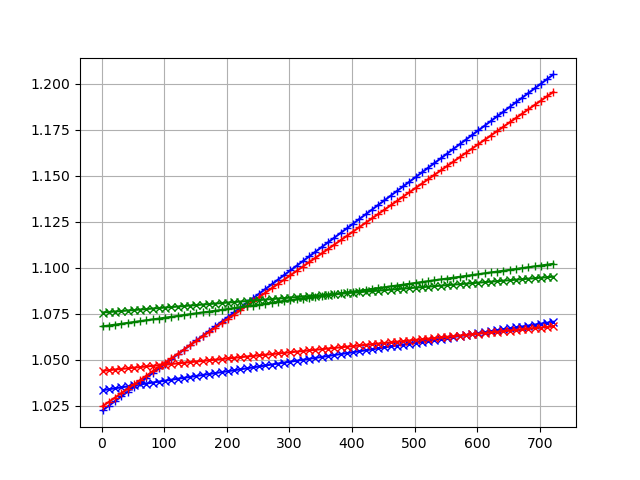

In [39]:
plt.figure()
plt.plot(delta_T_NCEP,params_morceaux_Gain_Derive_NCEP[0,0]*(1+params_morceaux_Gain_Derive_NCEP[0,1]/100*delta_T_NCEP/365),'+-b')
plt.plot(delta_T_NCEP,params_morceaux_Gain_Derive_NCEP[1,0]*(1+params_morceaux_Gain_Derive_NCEP[1,1]/100*delta_T_NCEP/365),'x-b')
plt.plot(delta_T_NCEP,params_morceaux_Gain_Derive_CarryOver[0,0]*(1+params_morceaux_Gain_Derive_CarryOver[0,1]/100*delta_T_NCEP/365),'+-r')
plt.plot(delta_T_NCEP,params_morceaux_Gain_Derive_CarryOver[1,0]*(1+params_morceaux_Gain_Derive_CarryOver[1,1]/100*delta_T_NCEP/365),'x-r')
plt.plot(delta_T_NCEP,params_morceaux_Gain_Derive_WOA[0,0]*(1+params_morceaux_Gain_Derive_WOA[0,1]/100*delta_T_NCEP/365),'+-g')
plt.plot(delta_T_NCEP,params_morceaux_Gain_Derive_WOA[1,0]*(1+params_morceaux_Gain_Derive_WOA[1,1]/100*delta_T_NCEP/365),'x-g')
plt.grid()

In [40]:
delta_T_intersect_Gain_Derive_NCEP = (36500 * (params_morceaux_Gain_Derive_NCEP[0,0] - params_morceaux_Gain_Derive_NCEP[1,0])) / (params_morceaux_Gain_Derive_NCEP[1,0] * params_morceaux_Gain_Derive_NCEP[1,1] - params_morceaux_Gain_Derive_NCEP[0,0] * params_morceaux_Gain_Derive_NCEP[0,1])
delta_T_intersect_Gain_Derive_CarryOver = (36500 * (params_morceaux_Gain_Derive_CarryOver[0,0] - params_morceaux_Gain_Derive_CarryOver[1,0])) / (params_morceaux_Gain_Derive_CarryOver[1,0] * params_morceaux_Gain_Derive_CarryOver[1,1] - params_morceaux_Gain_Derive_CarryOver[0,0] * params_morceaux_Gain_Derive_CarryOver[0,1])
delta_T_intersect_Gain_Derive_WOA = (36500 * (params_morceaux_Gain_Derive_WOA[0,0] - params_morceaux_Gain_Derive_WOA[1,0])) / (params_morceaux_Gain_Derive_WOA[1,0] * params_morceaux_Gain_Derive_WOA[1,1] - params_morceaux_Gain_Derive_WOA[0,0] * params_morceaux_Gain_Derive_WOA[0,1])

In [41]:
print(delta_T_intersect_Gain_Derive_NCEP)
print(delta_T_intersect_Gain_Derive_CarryOver)
print(delta_T_intersect_Gain_Derive_WOA)

55.97317724161968
96.23241164301504
374.50261306810717


In [42]:
print(params_Gain_WOA)
print(params_Gain_Derive_WOA)
print(params_Gain_NCEP)
print(params_Gain_Derive_NCEP)
print(params_Gain_NCEP_CarryOver)
print(params_Gain_Derive_NCEP_CarryOver)
print(params_morceaux_Gain_Derive_NCEP)
print(params_morceaux_Gain_Derive_CarryOver)
print(params_morceaux_Gain_Derive_WOA)

[1.08397923]
[1.07134826 1.20659892]
[1.05285767]
[1.03501173 1.71695165]
[1.05556815]
[1.03977712 1.4770446 ]
[[1.02197312 9.06857456]
 [1.03329312 1.82532007]]
[[1.02424159 8.46759195]
 [1.04387341 1.17514929]]
[[1.06800355 1.61704548]
 [1.07558829 0.91836414]]


GAIN WOA
[1.08397923]
Gain NCEP
[1.05285767]
Gain/Derive WOA
[1.07134826 1.20659892]
Gain/Derive Ncep
[1.03501173 1.71695165]
Gain Ncep CarryOver
[1.05556815]
Gain/Derive Ncep CarryOver
[1.03977712 1.4770446 ]
GAIN WOA
[1.08397923]
Gain NCEP
[1.05285767]
Gain/Derive WOA
[1.07134826 1.20659892]
Gain/Derive Ncep
[1.03501173 1.71695165]
Gain Ncep CarryOver
[1.05556815]
Gain/Derive Ncep CarryOver
[1.03977712 1.4770446 ]


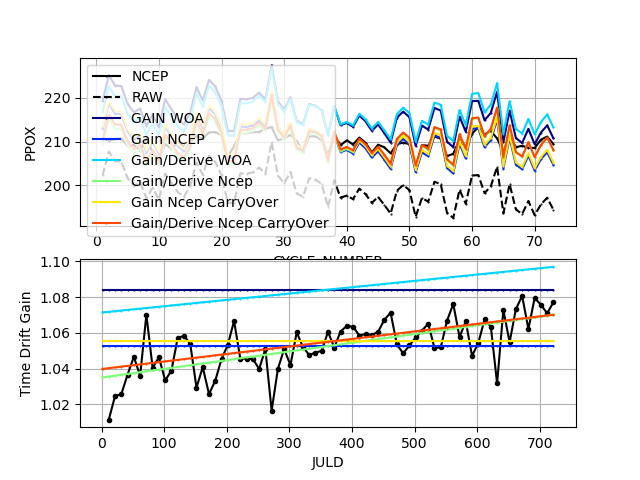

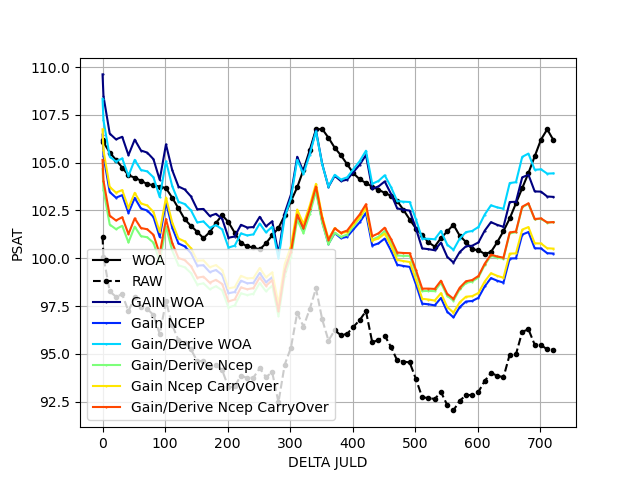

In [43]:
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : params_Gain_NCEP_CarryOver,'Gain/Derive Ncep CarryOver' : params_Gain_Derive_NCEP_CarryOver}
deltaT_list=[[]] * len(dict_corr)
_=plot_cmp_corr_NCEP(dict_corr,deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
#_=plot_cmp_corr_NCEP_old(dict_corr,dsair,NCEP_PPOX,delta_T_NCEP)
#_=plot_cmp_corr_WOA_old(dict_corr, ds_argo_interp, ds_woa_interp, delta_T_WOA)
_=plot_cmp_corr_WOA(dict_corr, deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)

Gain/Derive Ncep CarryOver
[1.03977712 1.4770446 ]
Gain/Derive Ncep CarryOver Morceaux
[1.02424159 8.46759195]
[1.04387341 1.17514929]
Gain/Derive Ncep CarryOver
[1.03977712 1.4770446 ]
Gain/Derive Ncep CarryOver Morceaux
[1.02424159 8.46759195]
[1.04387341 1.17514929]


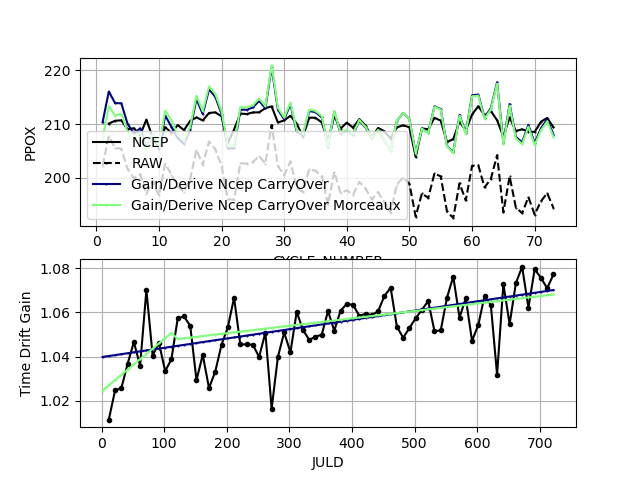

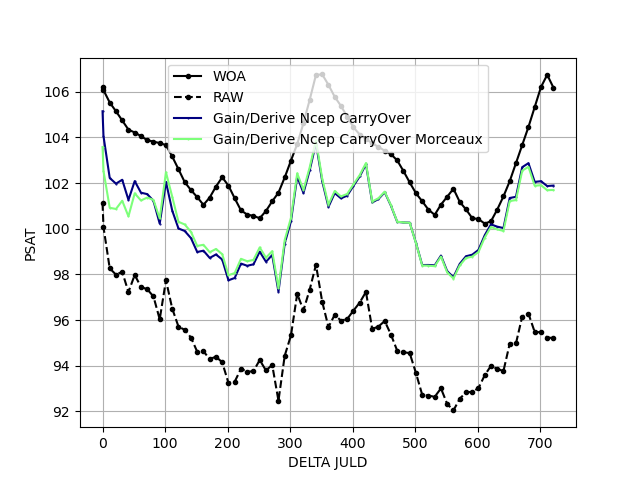

In [44]:
dict_corr = {'Gain/Derive Ncep CarryOver' : params_Gain_Derive_NCEP_CarryOver,'Gain/Derive Ncep CarryOver Morceaux' : params_morceaux_Gain_Derive_CarryOver}
deltaT_list = [[],[0,115,delta_T_sprof.values[-1]+1]]
_=plot_cmp_corr_NCEP(dict_corr,deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
#_=plot_cmp_corr_NCEP_old(dict_corr,dsair,NCEP_PPOX,delta_T_NCEP)
#_=plot_cmp_corr_WOA_old(dict_corr, ds_argo_interp, ds_woa_interp, delta_T_WOA)
_=plot_cmp_corr_WOA(dict_corr, deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)

Gain/Derive Ncep morceaux
[1.02197312 9.06857456]
[1.03329312 1.82532007]
Gain/Derive Ncep CarryOver Morceaux
[1.02424159 8.46759195]
[1.04387341 1.17514929]
Gain/Derive WOA morceaux
[1.06800355 1.61704548]
[1.07558829 0.91836414]
Gain/Derive Ncep morceaux
[1.02197312 9.06857456]
[1.03329312 1.82532007]
Gain/Derive Ncep CarryOver Morceaux
[1.02424159 8.46759195]
[1.04387341 1.17514929]
Gain/Derive WOA morceaux
[1.06800355 1.61704548]
[1.07558829 0.91836414]


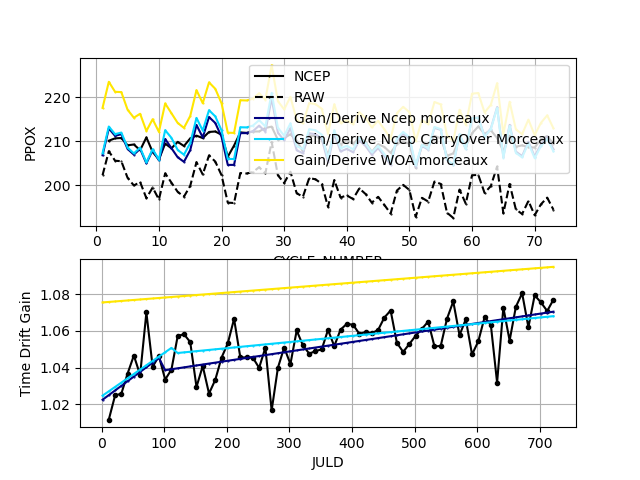

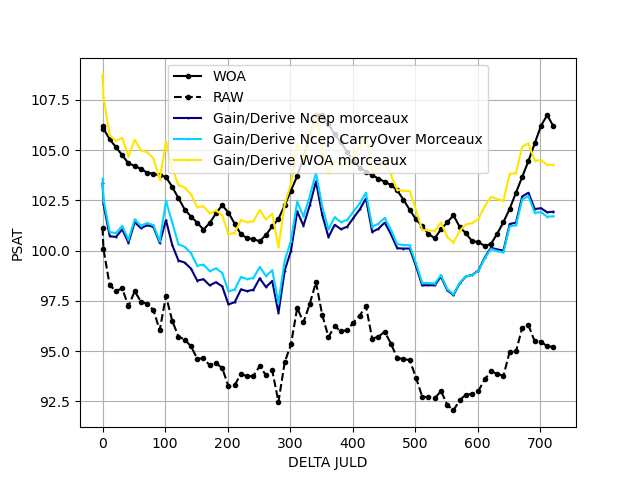

In [45]:
deltaT_list = [[0,92,delta_T_sprof.values[-1]+1],[0,115,delta_T_sprof.values[-1]+1],[0,0,delta_T_sprof.values[-1]+1]]
dict_corr = {'Gain/Derive Ncep morceaux' : params_morceaux_Gain_Derive_NCEP,'Gain/Derive Ncep CarryOver Morceaux' : params_morceaux_Gain_Derive_CarryOver,
            'Gain/Derive WOA morceaux' : params_morceaux_Gain_Derive_WOA}
_=plot_cmp_corr_NCEP(dict_corr,deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
_=plot_cmp_corr_WOA(dict_corr,deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)

In [50]:
params_Gain_Derive_NCEP_CarryOver

array([1.03977712, 1.4770446 ])

In [51]:
# Which correction to keep/apply
#params_to_keep = gain_Derive_CarryOver #params_Gain_Derive_NCEP
import copy
params_to_keep =copy.deepcopy(params_Gain_Derive_NCEP_CarryOver)
breakpoints_cycle = [] 



print(f'Correction : Gain and Drift : {params_to_keep}')


# Init Pressure correction (0 by default) and a supplement gain form CTD (1 by default)
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])

oxy_ctd_tot = np.array([])
cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])
oxy_pour_pres_tot = np.array([])
pres_pour_pres_tot = np.array([])
cycle_pour_pres_tot = np.array([])

# Compare ARGO Profil  with  CTD 
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        
        # In Locodox, the CTD is on a regular pressure grid
        #oxy_ctd_interp1 = np.interp(np.arange(0,4010,10),ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))
        #oxy_ctd_interp = np.interp(ds_cycle['PRES'],np.arange(0,4010,10),oxy_ctd_interp1)
        oxy_ctd_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))

        oxy_ctd_tot = np.concatenate((oxy_ctd_tot,oxy_ctd_interp),axis=None)

        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))

        if len(breakpoints_cycle)>0:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breakpoints_cycle)) if val>= num_cycle[i_ctd])
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep
            

        if len(params_ok)==1:
            params_ok[1] = 0 # No drift correction
        print(f'Correction utilise pour le cycle en cours : {params_ok}')

        #dict_corr = {'Correction' : params_ok}
        #print(params_ok)
        #_=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 

        # Information for correction for the cycle associated to the CTD
        cycle_corr = model_Gain_Derive([ds_cycle['DOXY'].isel(N_PROF=0).values,tab_delta_T],*params_ok)
        cycle_corr_tot = np.concatenate((cycle_corr_tot,cycle_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)

        # Information for pressure effect correction
        PRES_1D = ds_cycle['PRES'].squeeze()  
        mask = PRES_1D >= pressure_threshold
        pres_pour_pres_tot = np.concatenate((pres_pour_pres_tot,ds_cycle['PRES'].sel(N_LEVELS=mask)),axis=None)
        oxy_pour_pres_tot = np.concatenate((oxy_pour_pres_tot,oxy_ctd_interp[0][mask.values]),axis=None)   
        cycle_pour_pres_tot = np.concatenate((cycle_pour_pres_tot,cycle_corr[0][mask.values]),axis=None)



    #plt.figure()
    #_=plt.plot(oxy_ctd_tot,pres_corr_tot,'x-b')
    #_=plt.plot(cycle_corr_tot,pres_corr_tot,'x-r')
    #_=plt.plot(cycle_pour_pres_tot,pres_pour_pres_tot,'+-k')
    #_=plt.plot(oxy_pour_pres_tot,pres_pour_pres_tot,'+-g')
    #plt.gca().invert_yaxis()
    #plt.grid()
    #oxy_ctd_tot = np.array(oxy_ctd_tot).flatten()
    #cycle_corr_tot = np.array(cycle_corr_tot).flatten()
    #pres_corr_tot = np.array(pres_corr_tot).flatten()
    #pres_pour_pres_tot = np.array(pres_pour_pres_tot).flatten()
    #oxy_pour_pres_tot = np.array(oxy_pour_pres_tot).flatten()
    #cycle_pour_pres_tot = np.array(cycle_pour_pres_tot).flatten()

    #print(oxy_ctd_tot.shape)
    #print(cycle_corr_tot.shape)
    #print(pres_corr_tot.shape)
    #print(cycle_pour_pres_tot.shape)
    #print(oxy_pour_pres_tot.shape)
    #print(cycle_pour_pres_tot.shape)

    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')
    # Solution with pressure effect correction
    print('Pressure effect Estimation')
    initial_guess = [0]   
    params_corr_pressure, covariance = curve_fit(model_corr_pres, [cycle_pour_pres_tot,pres_pour_pres_tot], oxy_pour_pres_tot, p0=initial_guess,nan_policy='omit') 
    cycle_corr_tot = model_corr_pres([cycle_corr_tot,pres_corr_tot],*params_corr_pressure)
    initial_guess = 0
    # CTD Gain estimation with pressure effect correction
    params_Gain_CTD_with_pressure, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')

   # _=plt.plot(cycle_corr*params_Gain_CTD[0],ds_cycle['PRES'],'.-c')


print(params_Gain_CTD)
print(params_corr_pressure)
print(params_Gain_CTD_with_pressure)

Correction : Gain and Drift : [1.03977712 1.4770446 ]
Correction utilise pour le cycle en cours : [1.03977712 1.4770446 ]
Pressure effect Estimation
[1.03030292]
[0.01371267]
[1.01081343]


In [53]:
#params_to_keep = params_morceaux_Gain_Derive_CarryOver
#params_to_keep = params_Gain_Derive_NCEP_CarryOver

derive_final = 0
if params_to_keep.ndim == 1:
    gain_final = params_Gain_CTD[0] * params_to_keep[0]
    derive_final = params_to_keep[1]
    corr_final_without_pressure_correction = np.array([gain_final,derive_final,params_no_corr_pressure[0]])
    gain_final_with_pressure = params_Gain_CTD_with_pressure[0] * params_to_keep[0]
    corr_final_with_pressure_correction = np.array([gain_final_with_pressure,derive_final,params_corr_pressure[0]])

else :
    gain_final = params_Gain_CTD[0] * params_to_keep[:,0]
    gain_final_with_pressure = params_Gain_CTD_with_pressure[0] * params_to_keep[:,0]
    derive_final = params_to_keep[:,1]
    val_bid=np.tile(params_no_corr_pressure[0],(1,len(breakpoints_cycle)-1))
    corr_final_without_pressure_correction = np.array([gain_final,derive_final,val_bid[0]])
    val_bid=np.tile(params_corr_pressure[0],(1,len(breakpoints_cycle)-1))
    corr_final_with_pressure_correction = np.array([gain_final_with_pressure,derive_final,val_bid[0]])


print(f'Final Correction without pressure effect : {corr_final_without_pressure_correction}')
print(f'Final Correction with pressure effect : {corr_final_with_pressure_correction}')

Final Correction without pressure effect : [1.0712854 1.4770446 0.       ]
Final Correction with pressure effect : [1.05102068 1.4770446  0.01371267]


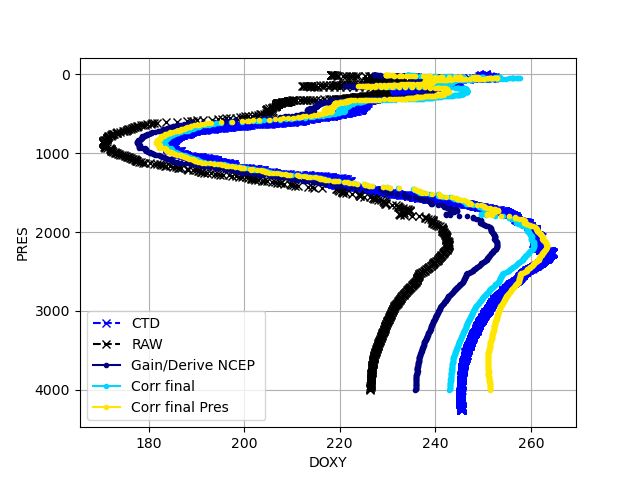

In [54]:
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        if len(breakpoints_cycle)>0:
            index = next(x for x, val in enumerate(np.array(breakpoints_cycle)) if val>= num_cycle[i_ctd])
            if index > 0:
                index = index -1
            dict_corr = {'Gain/Derive NCEP Morceaux' : params_to_keep[index,:],'Corr final' :corr_final_without_pressure_correction[:,index],'Corr final pres' : corr_final_with_pressure_correction[:,index]}
        else:
            dict_corr = {'Gain/Derive NCEP ' : params_to_keep,'Corr final' :corr_final_without_pressure_correction,'Corr final Pres' :corr_final_with_pressure_correction}
        
        _=plot_cmp_ARGO_CTD(ds_cruise,ds_cycle,dict_corr,launch_date) 


Correction : Gain and Drift : [1.03977712 1.4770446 ]
Correction utilise pour le cycle en cours : [1.03977712 1.4770446 ]
Pressure effect Estimation
[1.03235124]
[0.01327319]
[1.01064638]


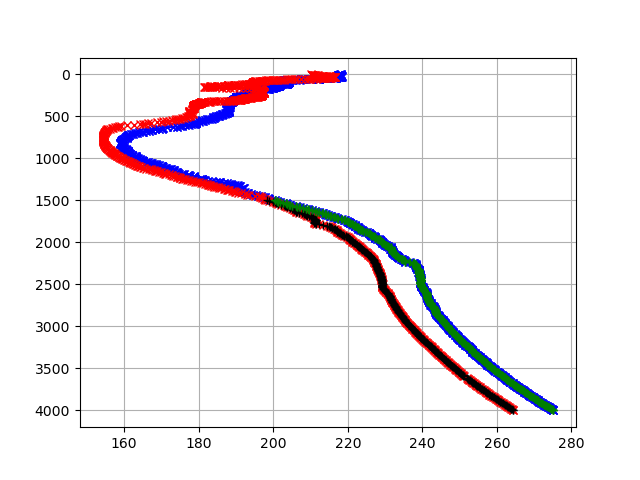

In [57]:
# Which correction to keep/apply


import copy
params_to_keep =copy.deepcopy(params_Gain_Derive_NCEP_CarryOver)
breakpoints_cycle = [] 



print(f'Correction : Gain and Drift : {params_to_keep}')


# Init Pressure correction (0 by default) and a supplement gain form CTD (1 by default)
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])

oxy_ctd_tot = np.array([])
cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])
oxy_pour_pres_tot = np.array([])
pres_pour_pres_tot = np.array([])
cycle_pour_pres_tot = np.array([])

# Compare ARGO Profil  with  CTD  PPOX
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)

        ana_dens = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_ARGO_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens)
        ppox_cruise = O2ctoO2p(O2_ARGO_umolL,ds_cruise['TEMP'],ds_cruise['PSAL'],ds_cruise['PRES']) # On calcule PPOX pour P=0
        oxy_ctd_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        oxy_ctd_tot = np.concatenate((oxy_ctd_tot,oxy_ctd_interp),axis=None)

        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))

        if len(breakpoints_cycle)>0:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breakpoints_cycle)) if val>= num_cycle[i_ctd])
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep
            

        if len(params_ok)==1:
            params_ok[1] = 0 # No drift correction
        print(f'Correction utilise pour le cycle en cours : {params_ok}')



        ana_dens = sw.pden(ds_cycle['PSAL_ADJUSTED'],ds_cycle['TEMP_ADJUSTED'],ds_cycle['PRES_ADJUSTED'],0)
        O2_ARGO_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens)
        ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_cycle['TEMP_ADJUSTED'],ds_cycle['PSAL_ADJUSTED'],ds_cycle['PRES_ADJUSTED']) # On calcule PPOX pour P=0
        ppox_ARGO_corr = model_Gain_Derive([ppox_ARGO,tab_delta_T],*params_ok)
        cycle_corr_tot = np.concatenate((cycle_corr_tot,ppox_ARGO_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)
 

        # Information for pressure effect correction
        PRES_1D = ds_cycle['PRES'].squeeze()  
        mask = PRES_1D >= pressure_threshold
        pres_pour_pres_tot = np.concatenate((pres_pour_pres_tot,ds_cycle['PRES'].sel(N_LEVELS=mask)),axis=None)
        oxy_pour_pres_tot = np.concatenate((oxy_pour_pres_tot,oxy_ctd_interp[0][mask.values]),axis=None)   
        cycle_pour_pres_tot = np.concatenate((cycle_pour_pres_tot,ppox_ARGO_corr[0][mask.values]),axis=None)




    plt.figure()
    _=plt.plot(oxy_ctd_tot,pres_corr_tot,'x-b')
    _=plt.plot(cycle_corr_tot,pres_corr_tot,'x-r')
    _=plt.plot(cycle_pour_pres_tot,pres_pour_pres_tot,'+-k')
    _=plt.plot(oxy_pour_pres_tot,pres_pour_pres_tot,'+-g')
    plt.gca().invert_yaxis()
    plt.grid()
    #oxy_ctd_tot = np.array(oxy_ctd_tot).flatten()
    #cycle_corr_tot = np.array(cycle_corr_tot).flatten()
    #pres_corr_tot = np.array(pres_corr_tot).flatten()
    #pres_pour_pres_tot = np.array(pres_pour_pres_tot).flatten()
    #oxy_pour_pres_tot = np.array(oxy_pour_pres_tot).flatten()
    #cycle_pour_pres_tot = np.array(cycle_pour_pres_tot).flatten()

    #print(oxy_ctd_tot.shape)
    #print(cycle_corr_tot.shape)
    #print(pres_corr_tot.shape)
    #print(cycle_pour_pres_tot.shape)
    #print(oxy_pour_pres_tot.shape)
    #print(cycle_pour_pres_tot.shape)

    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')
    # Solution with pressure effect correction
    print('Pressure effect Estimation')
    initial_guess = [0]   
    params_corr_pressure, covariance = curve_fit(model_corr_pres, [cycle_pour_pres_tot,pres_pour_pres_tot], oxy_pour_pres_tot, p0=initial_guess,nan_policy='omit') 
    cycle_corr_tot = model_corr_pres([cycle_corr_tot,pres_corr_tot],*params_corr_pressure)
    initial_guess = 0
    # CTD Gain estimation with pressure effect correction
    params_Gain_CTD_with_pressure, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')

   # _=plt.plot(cycle_corr*params_Gain_CTD[0],ds_cycle['PRES'],'.-c')


print(params_Gain_CTD)
print(params_corr_pressure)
print(params_Gain_CTD_with_pressure)

In [58]:
#params_to_keep = params_morceaux_Gain_Derive_CarryOver
#params_to_keep = params_Gain_Derive_NCEP_CarryOver

derive_final = 0
if params_to_keep.ndim == 1:
    gain_final = params_Gain_CTD[0] * params_to_keep[0]
    derive_final = params_to_keep[1]
    corr_final_without_pressure_correction = np.array([gain_final,derive_final,params_no_corr_pressure[0]])
    gain_final_with_pressure = params_Gain_CTD_with_pressure[0] * params_to_keep[0]
    corr_final_with_pressure_correction = np.array([gain_final_with_pressure,derive_final,params_corr_pressure[0]])

else :
    gain_final = params_Gain_CTD[0] * params_to_keep[:,0]
    gain_final_with_pressure = params_Gain_CTD_with_pressure[0] * params_to_keep[:,0]
    derive_final = params_to_keep[:,1]
    val_bid=np.tile(params_no_corr_pressure[0],(1,len(breakpoints_cycle)-1))
    corr_final_without_pressure_correction = np.array([gain_final,derive_final,val_bid[0]])
    val_bid=np.tile(params_corr_pressure[0],(1,len(breakpoints_cycle)-1))
    corr_final_with_pressure_correction = np.array([gain_final_with_pressure,derive_final,val_bid[0]])


print(f'Final Correction without pressure effect : {corr_final_without_pressure_correction}')
print(f'Final Correction with pressure effect : {corr_final_with_pressure_correction}')

Final Correction without pressure effect : [1.0734152 1.4770446 0.       ]
Final Correction with pressure effect : [1.05084698 1.4770446  0.01327319]


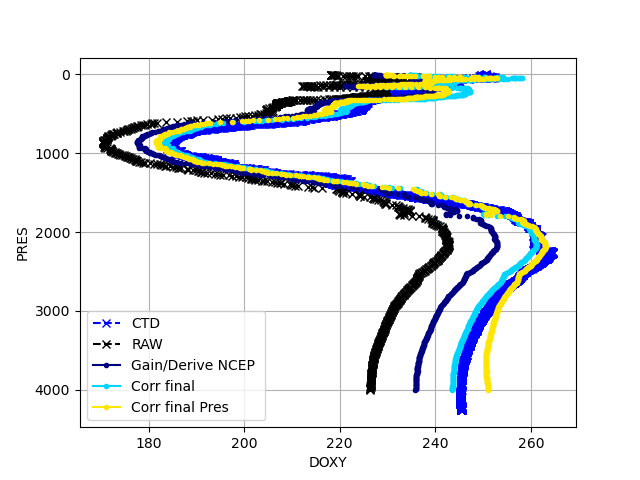

In [61]:
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        if len(breakpoints_cycle)>0:
            index = next(x for x, val in enumerate(np.array(breakpoints_cycle)) if val>= num_cycle[i_ctd])
            if index > 0:
                index = index -1
            dict_corr = {'Gain/Derive NCEP Morceaux' : params_to_keep[index,:],'Corr final' :corr_final_without_pressure_correction[:,index],'Corr final Pres' :corr_final_with_pressure_correction[:,index]}
        else:
            dict_corr = {'Gain/Derive NCEP ' : params_to_keep,'Corr final' :corr_final_without_pressure_correction,'Corr final Pres' :corr_final_with_pressure_correction}
        
        _=plot_cmp_ARGO_CTD(ds_cruise,ds_cycle,dict_corr,launch_date) 

        

In [65]:
#
# Which correction to apply.
#
breakpoints_delta_T = []

corr_final_to_use = corr_final_without_pressure_correction

val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
fic_argo.sort()
#
# Modifier pour ne corriger que les cycles entre first cycle et last cycle ?...
# A faire seulement si saut dans les donnees ???
#
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
comment_corr = 'Adjustement made with NCEP for Gain/Drift by piece + Gain with CTD RREX 26'
for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    ds = xr.open_dataset(fic_en_cours,engine='argo')
    cycle_en_cours = ds['CYCLE_NUMBER'].values[0]
    juld_en_cours = ds['JULD'].values[0]
    delta_T_en_cours = diff_time_in_days(juld_en_cours,launch_date)
    if (cycle_en_cours >= first_cycle_to_use) & (cycle_en_cours<=last_cycle_to_use):
        if len(breakpoints_delta_T)>0:
        #if len(breakpoints_cycle)>0:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            #index = next(x for x, val in enumerate(np.array(breakpoints_cycle)) if val>= cycle_en_cours)
            index = next(x for x, val in enumerate(np.array(breakpoints_delta_T)) if val>= delta_T_en_cours)

            if index > 0:
                index = index -1
            corr_final = corr_final_to_use[:,index]
        else :
            corr_final = corr_final_to_use
    
        coef_pres = corr_final[2]
        gain_final = corr_final[0]
        derive_final = corr_final[1]  
        coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, COEF_PRES ={coef_pres},OFFSET=0.000000, DRIFT2=0.000000'
        eq_corr = 'DOXY2 = (1 +coef_press *PRES/1000) * DOXY,DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365+DRIFT2/100.*(profile_date_juld-launch_date_juld)**2/365**2)+INCLINE_T*TEMP)*DOXY2'
        print(f'Correction de {fic_en_cours} avec {corr_final}')
        if os.path.exists(fic_res):
            os.remove(fic_res)
        corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,gain_final,derive_final,coef_pres,percent_relative_error)

Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_001.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_002.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_003.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_004.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_005.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_006.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_007.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/gdac/dac/coriolis/6903080/profiles/BD6903080_008.nc avec [1.0734152 1.4770446 0.       ]
Correction de /Volumes/ref-argo/